
=== Summary Statistics and T-Tests ===

Feature: bonsai_dm
  Repeater mean: 442.800018, median: 349.399994
  Non-repeater mean: 645.107056, median: 541.900024
  T-test: t = -5.10, p = 2.21e-06

Feature: width_fitb (nonzero only)
  Repeater mean: 0.002630, median: 0.001839
  Non-repeater mean: 0.001635, median: 0.001020
  T-test: t = 2.20, p = 0.0323

Feature: fluence
  Repeater mean: 13.122449, median: 6.100000
  Non-repeater mean: 7.863615, median: 3.900000
  T-test: t = 2.55, p = 0.0136

Feature: flux
  Repeater mean: 1.461428, median: 0.970000
  Non-repeater mean: 1.814739, median: 0.890000
  T-test: t = -1.54, p = 0.127

Feature: bandwidth
  Repeater mean: 200.430603, median: 205.099976
  Non-repeater mean: 297.933380, median: 318.900024
  T-test: t = -9.01, p = 1.75e-13

Feature: scat_time (nonzero only)
  Repeater mean: 0.003012, median: 0.002000
  Non-repeater mean: 0.003657, median: 0.001400
  T-test: t = -0.82, p = 0.414


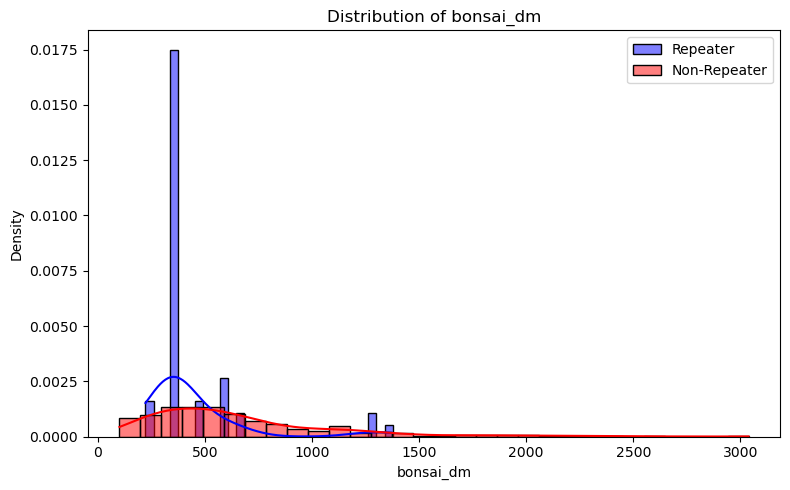

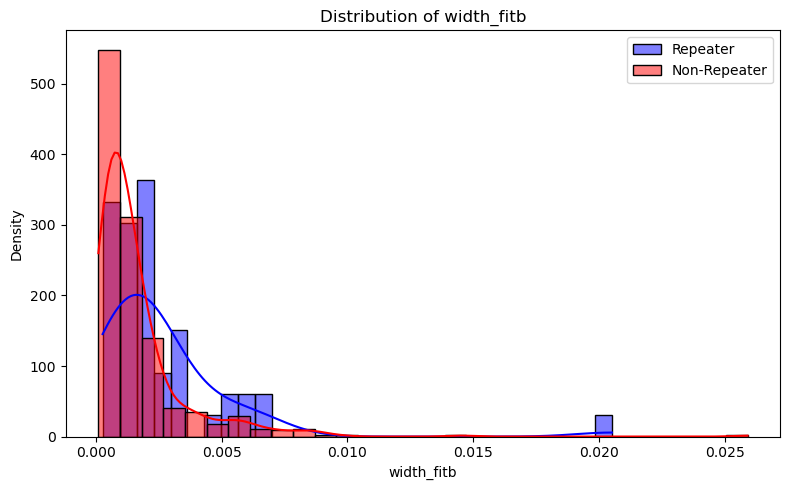

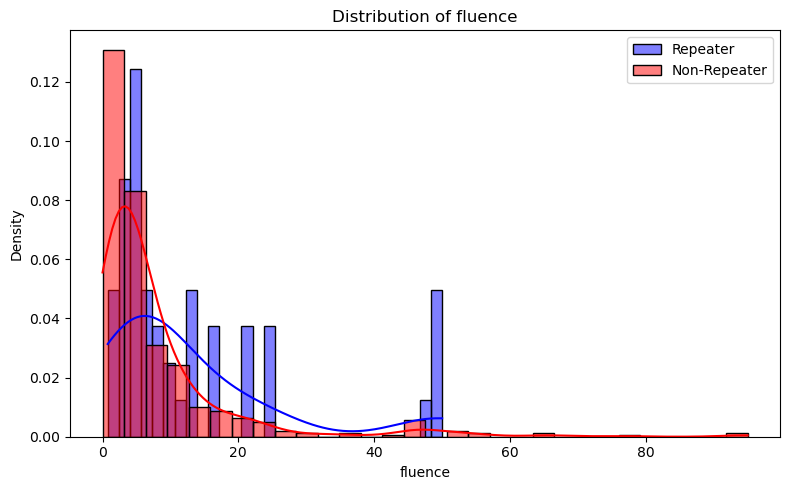

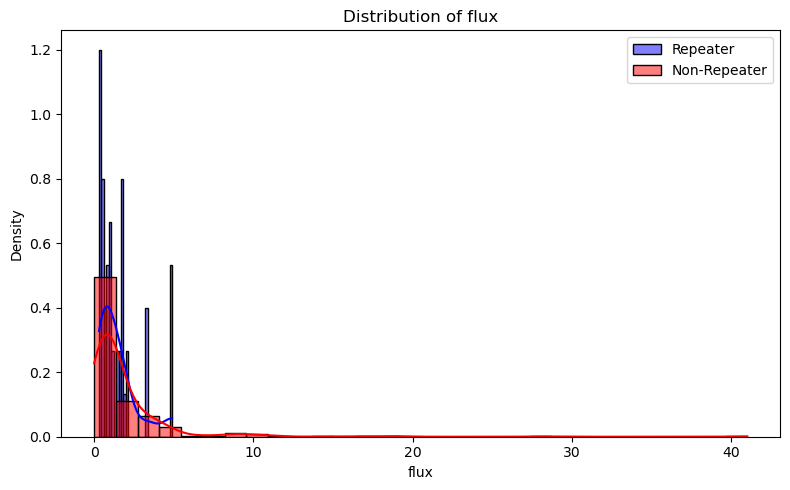

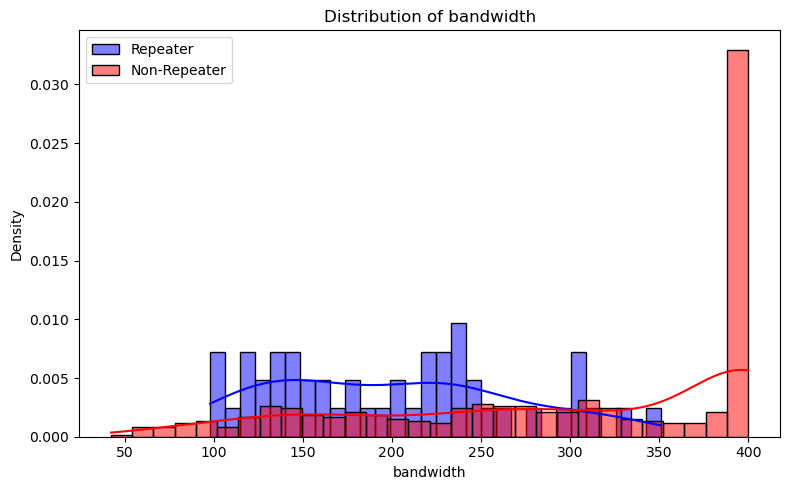

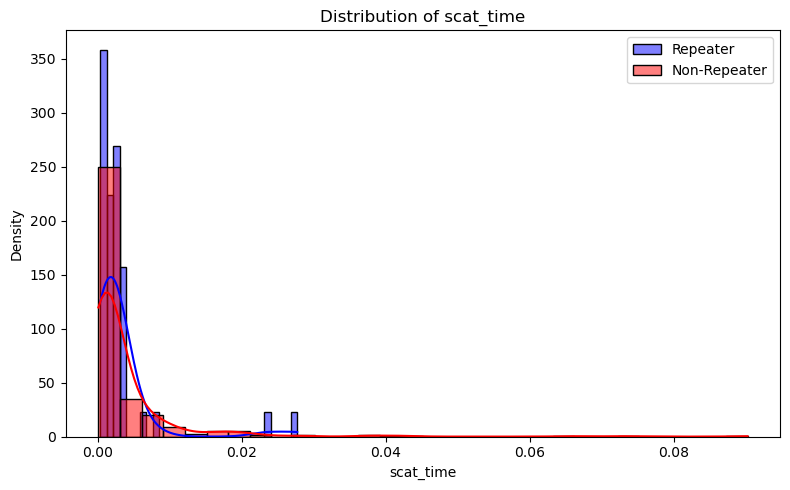

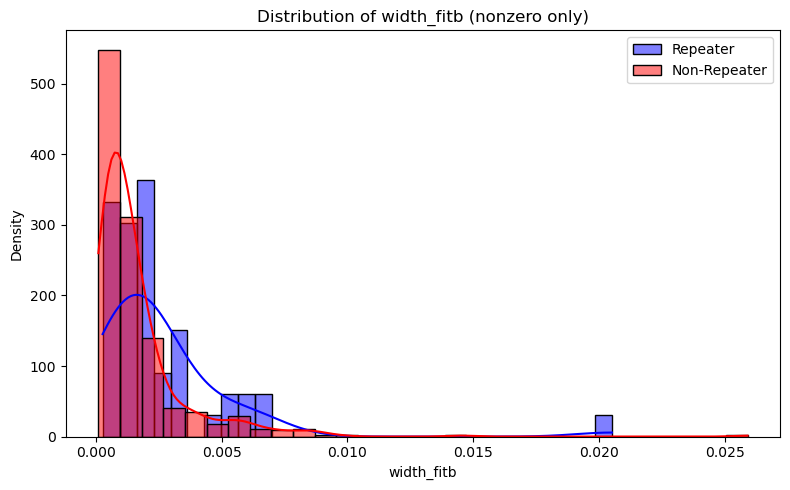

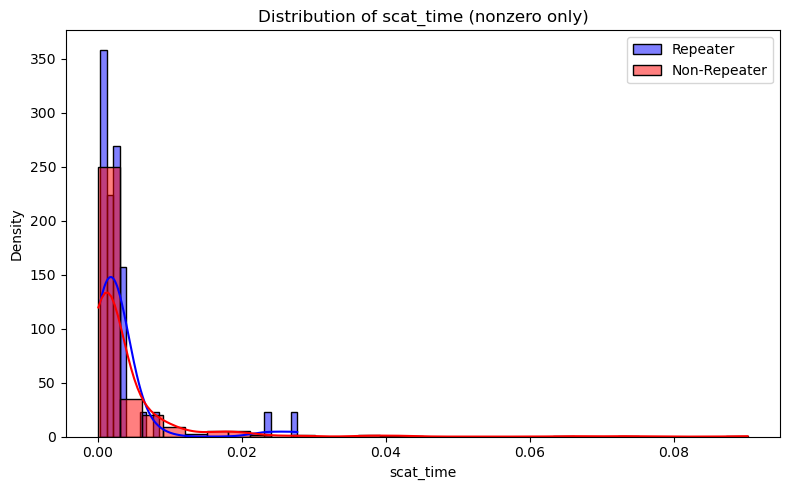


=== Correlation Matrix (Repeaters) ===
            bonsai_dm  width_fitb   fluence      flux  bandwidth  scat_time
bonsai_dm    1.000000    0.442116  0.079434 -0.231718  -0.098377   0.690478
width_fitb   0.442116    1.000000  0.357583 -0.072579   0.037425   0.597201
fluence      0.079434    0.357583  1.000000  0.823060   0.110538   0.145108
flux        -0.231718   -0.072579  0.823060  1.000000   0.115149  -0.244185
bandwidth   -0.098377    0.037425  0.110538  0.115149   1.000000   0.070209
scat_time    0.690478    0.597201  0.145108 -0.244185   0.070209   1.000000

=== Correlation Matrix (Non-Repeaters) ===
            bonsai_dm  width_fitb   fluence      flux  bandwidth  scat_time
bonsai_dm    1.000000    0.055220 -0.113557 -0.163056   0.199736   0.084658
width_fitb   0.055220    1.000000  0.121380 -0.152220  -0.059792   0.385110
fluence     -0.113557    0.121380  1.000000  0.643088   0.080049   0.210913
flux        -0.163056   -0.152220  0.643088  1.000000   0.112480  -0.122078
band

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits
from astropy.table import Table
import pandas as pd
from scipy import stats

# Load the FITS file
filename = "chimefrbcat1.fits"
with fits.open(filename) as hdul:
    full_table = Table(hdul[1].data)

# Filter to included bursts
table = full_table[full_table['excluded_flag'] == 0]

# Define known repeaters
known_repeaters = {
    'FRB20180916B', 'FRB20180924B', 'FRB20181017A', 'FRB20181112A', 'FRB20181124A',
    'FRB20181223A', 'FRB20190102C', 'FRB20190110C', 'FRB20190208A', 'FRB20190213A',
    'FRB20190214A', 'FRB20190222A', 'FRB20190226A', 'FRB20190303A', 'FRB20190312A',
    'FRB20190317B', 'FRB20190330A', 'FRB20190417A'}

# Tag repeaters
repeater_mask = np.array([name in known_repeaters for name in table['repeater_name']])
table['is_repeater'] = repeater_mask.astype(int)

# Split and convert to DataFrame
repeaters_df = table[table['is_repeater'] == 1].to_pandas()
nonrepeaters_df = table[table['is_repeater'] == 0].to_pandas()

# Compute bandwidth
repeaters_df['bandwidth'] = repeaters_df['high_freq'] - repeaters_df['low_freq']
nonrepeaters_df['bandwidth'] = nonrepeaters_df['high_freq'] - nonrepeaters_df['low_freq']

# Features to analyze
features = ['bonsai_dm', 'width_fitb', 'fluence', 'flux', 'bandwidth', 'scat_time']

# === Print means, medians, and t-tests (nonzero-aware where needed)
print("\n=== Summary Statistics and T-Tests ===")
for feature in features:
    # Use nonzero-only filtering for these
    if feature in ['width_fitb', 'scat_time']:
        r_data = repeaters_df[repeaters_df[feature] > 0][feature]
        nr_data = nonrepeaters_df[nonrepeaters_df[feature] > 0][feature]
        note = " (nonzero only)"
    else:
        r_data = repeaters_df[feature]
        nr_data = nonrepeaters_df[feature]
        note = ""

    r_mean, r_median = r_data.mean(), r_data.median()
    nr_mean, nr_median = nr_data.mean(), nr_data.median()
    tstat, pval = stats.ttest_ind(r_data, nr_data, equal_var=False, nan_policy='omit')

    print(f"\nFeature: {feature}{note}")
    print(f"  Repeater mean: {r_mean:.6f}, median: {r_median:.6f}")
    print(f"  Non-repeater mean: {nr_mean:.6f}, median: {nr_median:.6f}")
    print(f"  T-test: t = {tstat:.2f}, p = {pval:.3g}")

# === Histograms (full)
for feature in features:
    plt.figure(figsize=(8, 5))
    sns.histplot(repeaters_df[feature], color='blue', label='Repeater', kde=True, stat="density", bins=30)
    sns.histplot(nonrepeaters_df[feature], color='red', label='Non-Repeater', kde=True, stat="density", bins=30)
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Histograms (nonzero only for applicable features)
for feature in ['width_fitb', 'scat_time']:
    plt.figure(figsize=(8, 5))
    sns.histplot(repeaters_df[repeaters_df[feature] > 0][feature], color='blue', label='Repeater', kde=True, stat="density", bins=30)
    sns.histplot(nonrepeaters_df[nonrepeaters_df[feature] > 0][feature], color='red', label='Non-Repeater', kde=True, stat="density", bins=30)
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title(f'Distribution of {feature} (nonzero only)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Correlation matrices
print("\n=== Correlation Matrix (Repeaters) ===")
print(repeaters_df[features].corr())

print("\n=== Correlation Matrix (Non-Repeaters) ===")
print(nonrepeaters_df[features].corr())


In [9]:
df = pd.concat([repeaters_df, nonrepeaters_df], ignore_index=True)

# Binary label: 1 = repeater, 0 = non-repeater
df['label'] = df['is_repeater']

# Compute bandwidth again safely (in case of NaNs)
df['bandwidth'] = df['high_freq'] - df['low_freq']

# Log-transform physically heavy-tailed quantities
raw_features = [
    'bonsai_dm',
    'width_fitb',
    'fluence',
    'flux',
    'bandwidth',
    'scat_time'
]

for f in raw_features:
    df[f'log_{f}'] = np.log10(df[f].where(df[f] > 0))

# Final ML feature set
features = [f'log_{f}' for f in raw_features]

X = df[features]
y = df['label']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

In [11]:

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       n_estimators=500, random_state=42)

In [13]:
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    balanced_accuracy_score
)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       128
           1       0.67      0.67      0.67        12

    accuracy                           0.94       140
   macro avg       0.82      0.82      0.82       140
weighted avg       0.94      0.94      0.94       140

ROC AUC: 0.9830729166666666
Balanced Accuracy: 0.8177083333333333


In [14]:
importances = pd.Series(
    rf.feature_importances_,
    index=features
).sort_values(ascending=False)

print("\n=== Feature Importances ===")
print(importances)



=== Feature Importances ===
log_bandwidth     0.344373
log_bonsai_dm     0.232845
log_width_fitb    0.129397
log_fluence       0.125767
log_scat_time     0.102463
log_flux          0.065155
dtype: float64


In [25]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    rf,
    X_test,
    y_test,
    n_repeats=30,
    random_state=42,
    scoring='roc_auc'
)

perm_importance = pd.Series(
    perm.importances_mean,
    index=features
).sort_values(ascending=False)

print("\n=== Permutation Importances ===")
print(perm_importance)



=== Permutation Importances ===
log_bonsai_dm     0.158290
log_bandwidth     0.115234
log_fluence       0.038281
log_scat_time     0.010460
log_width_fitb    0.007595
log_flux         -0.005013
dtype: float64
